In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
from collections import defaultdict
from datetime import datetime
import h5py
import matplotlib.pyplot as plt
from neural_analysis.matIO import loadmat
import numpy as np
import os
import pandas as pd
import re
from scipy.signal import butter, filtfilt, freqz
import shutil
from sklearn.metrics import r2_score
import sys
import time
from tqdm.auto import tqdm

sys.path.append('../../..')
from ld_utils import compute_eigs, get_data_sigma_norms
from plot import plot_individual_areas, plot_multipopulation
from up_down import get_up_down
from utils import compile_folder, get_data_class, get_result_path, load, save

In [3]:
## propofolPuffTone
session = 'Mary-Anesthesia-20160809-01'
# session = 'MrJones-Anesthesia-20160105-01'
# session = 'Mary-Anesthesia-20160916-02'
# session = 'MrJones-Anesthesia-20160301-01'
# session = 'MrJones-Anesthesia-20160113-01'
# session = 'Mary-Anesthesia-20160818-02'
# session = 'MrJones-Anesthesia-20160121-01'

## propofolWakeup
# session = 'Mary-Anesthesia-20170203-02'

## ketamine
# session = 'Mary-Anesthesia-20170315-01'
# session = 'MrJones-Anesthesia-20160805-01'
# session = 'MrJones-Anesthesia-20160808-01'
# session = 'Mary-Anesthesia-20170315-01'

## Load Neural Data

In [4]:
all_data_dir = f"/om/user/eisenaj/datasets/anesthesia/mat"
data_class = get_data_class(session, all_data_dir)

In [5]:
filename = os.path.join(all_data_dir, data_class, f'{session}.mat')
print("Loading data ...")
start = time.process_time()
electrode_info, lfp, lfp_schema, session_info, spike_times, trial_info, unit_info = loadmat(filename, variables=['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'spikeTimes', 'trialInfo', 'unitInfo'], verbose=False)
# electrode_info, lfp_schema, session_info, spike_times, trial_info, unit_info = loadmat(filename, variables=['electrodeInfo', 'lfpSchema', 'sessionInfo', 'spikeTimes', 'trialInfo', 'unitInfo'], verbose=False)
spike_times = spike_times[0]
dt = lfp_schema['smpInterval'][0]
# T = lfp.shape[0]

print(f"Data loaded (took {time.process_time() - start:.2f} seconds)")

Loading data ...
Data loaded (took 150.35 seconds)


## Let's Just Do this For 1 Window

In [7]:
area1 = 'vlPFC'
area2 = 'CPB'

area1_indices = np.where(electrode_info['area'] == area1)[0]
area2_indices = np.where(electrode_info['area'] == area2)[0]

In [155]:
window_s = 2.5 # seconds
m_range = np.arange(1, 11)
lamb = 0
thresh = 0.95

window = int(window_s/dt)
i = 10
area1_chunk = lfp[i*window:(i+1)*window, area1_indices]
area2_chunk = lfp[i*window:(i+1)*window, area2_indices]

In [6]:
def reduced_rank_regression_analysis(X, Y, m_range=np.arange(1, 11), lamb=0):
     # compute ordinary least squares regression
    B_OLS = np.linalg.inv(X.T @ X + lamb*np.eye(X.shape[1])) @ X.T @ Y
    Y_hat_OLS = X @ B_OLS

    Rsquared_OLS = r2_score(Y, Y_hat_OLS)
    
    _, S, V_T = np.linalg.svd(Y_hat_OLS)
    
    RRR_data = {}
    for m in m_range:
        V = V_T[:m].T
        B_RRR = B_OLS@V@V.T
        Y_hat_RRR = X @ B_RRR

        Rsquared_RRR = r2_score(Y, Y_hat_RRR)
        
        RRR_data[m] = {'B_RRR': B_RRR, 'Y_hat_RRR': Y_hat_RRR, 'Rsquared_RRR': Rsquared_RRR}
    
    return RRR_data, B_OLS, Y_hat_OLS, Rsquared_OLS, S, V_T.T

In [152]:
RRR_data, B_OLS, Y_hat_OLS, Rsquared_OLS, S, V = reduced_rank_regression_analysis(area1_chunk, area2_chunk, m_range=m_range,lamb=lamb)

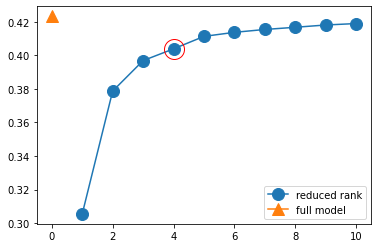

In [153]:
Rsquared_RRRs = [RRR_data[m]['Rsquared_RRR'] for m in m_range]
plt.plot(m_range, Rsquared_RRRs, 'o-', markersize=12, label='reduced rank')
plt.plot(0, Rsquared_OLS, markersize=12, marker="^", label='full model')
selected_dim_ind = np.argmax(Rsquared_RRRs > thresh*Rsquared_OLS)
selected_dim = m_range[selected_dim_ind]
plt.plot(selected_dim, Rsquared_RRRs[selected_dim_ind], marker='o', markerfacecolor='none', markeredgecolor='r', markersize=20)
plt.legend()
plt.show()

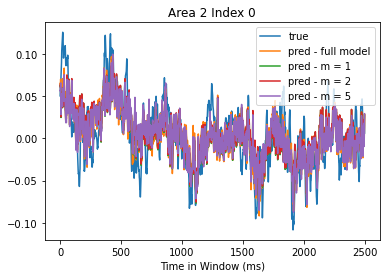

In [149]:
ind = 0
plt.plot(area2_chunk[:, ind], label='true')
plt.plot(Y_hat_OLS[:, ind], label='pred - full model')
for m in [1, 2, 5]:
    plt.plot(RRR_data[m]['Y_hat_RRR'][:, ind], label=f'pred - m = {m}')
plt.title(f'Area 2 Index {ind}')
plt.xlabel('Time in Window (ms)')
plt.legend()
plt.show()

## Okay now let's do this ... for all windows I guess

In [12]:
window_s = 2.5 # seconds
m_range = np.arange(1, 21)
lamb = 0
thresh = 0.95
# area_pairs = [('vlPFC', 'CPB'), ('CPB', 'vlPFC')]
area_pairs = []
for area1 in np.unique(electrode_info['area']):
    for area2 in np.unique(electrode_info['area']):
        if area1 != area2:
            area_pairs.append((area1, area2))

window = int(window_s/dt)
num_windows = int(lfp.shape[0]/window)

In [8]:
communication_subspace_data = {}
for area_pair in area_pairs:
    communication_subspace_data[area_pair] = []

iterator = tqdm(total = num_windows*len(area_pairs))
for area1, area2 in area_pairs:
    area1_indices = np.where(electrode_info['area'] == area1)[0]
    area2_indices = np.where(electrode_info['area'] == area2)[0]
    for i in range(num_windows):
        area1_chunk = lfp[i*window:(i+1)*window, area1_indices]
        area2_chunk = lfp[i*window:(i+1)*window, area2_indices]

        RRR_data, B_OLS, Y_hat_OLS, Rsquared_OLS, S, V = reduced_rank_regression_analysis(area1_chunk, area2_chunk, m_range=m_range,lamb=lamb)
        Rsquared_RRRs = [RRR_data[m]['Rsquared_RRR'] for m in m_range]
        indicator = Rsquared_RRRs > thresh*Rsquared_OLS
        if np.sum(indicator) == 0:
            selected_dim = m_range[-1]
        else:
            selected_dim_ind = np.argmax(indicator)
            selected_dim = m_range[selected_dim_ind]

        communication_subspace_data[(area1, area2)].append(dict(
            d=selected_dim,
            Rsquared_RRRs=Rsquared_RRRs,
            Rsquared_OLS=Rsquared_OLS,
            start_time=i*window_s,
            B_OLS=B_OLS,
            S=S,
            V=V,
        ))

        iterator.update()
iterator.close()

for area_pair in area_pairs:
    communication_subspace_data[area_pair] = pd.DataFrame(communication_subspace_data[area_pair])

  0%|          | 0/34008 [00:00<?, ?it/s]

In [9]:
save(communication_subspace_data, "/om/user/eisenaj/ChaoticConsciousness/results/propofolPuffTone/communication_subspace/test2")

In [8]:
communication_subspace_data = load("/om/user/eisenaj/ChaoticConsciousness/results/propofolPuffTone/communication_subspace/test2")

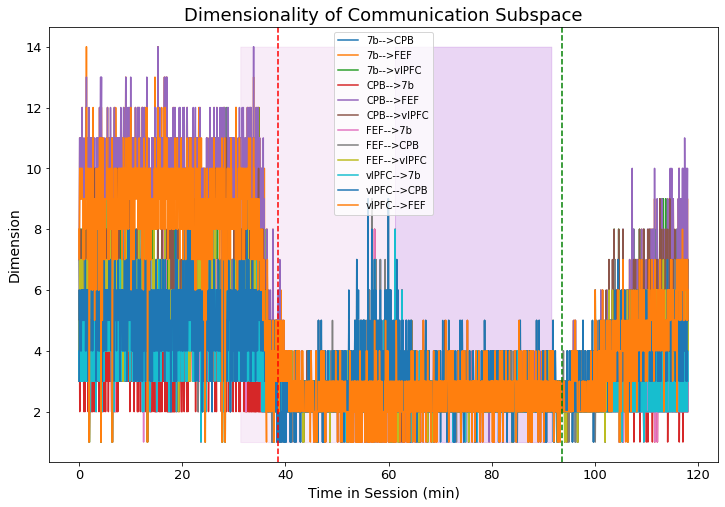

In [9]:
plt.figure(figsize=(12, 8))
min_val = np.Inf
max_val = -np.Inf
for area_pair in area_pairs:
    plt.plot(communication_subspace_data[area_pair].start_time/60, communication_subspace_data[area_pair].d, label=f"{area_pair[0]}-->{area_pair[1]}")
    if communication_subspace_data[area_pair].d.max() > max_val:
        max_val = communication_subspace_data[area_pair].d.max()
    if communication_subspace_data[area_pair].d.min() < min_val:
        min_val = communication_subspace_data[area_pair].d.min()
    
plt.legend()
plt.xlabel('Time in Session (min)', fontsize=14)
plt.title("Dimensionality of Communication Subspace", fontsize=18)
plt.ylabel("Dimension", fontsize=14)
plt.tick_params(labelsize=13)
ax = plt.gca()
ax.fill_between(np.arange(session_info['drugStart'][0], session_info['drugEnd'][0])/60, 
                                        min_val, max_val, color='plum', alpha=0.2, label=f"drug infusion 1 - dose = {session_info['drugDose'][0]}")
ax.fill_between(np.arange(session_info['drugStart'][1], session_info['drugEnd'][1])/60, 
                    min_val, max_val, color='darkorchid', alpha=0.2, label=f"drug infusion 2 - dose = {session_info['drugDose'][1]}")
plt.axvline(session_info['eyesClose'][-1]/60 if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose']/60, linestyle='--', c='red', label="loss of consciousness")
plt.axvline(session_info['eyesOpen'][-1]/60 if isinstance(session_info['eyesOpen'], np.ndarray) else session_info['eyesOpen']/60, linestyle='--', c='green', label="return of consciousness")
plt.show()

## Correlations

In [18]:
correlations = load('/om/user/eisenaj/ChaoticConsciousness/results/propofolPuffTone/correlations/correlations_Mary-Anesthesia-20160809-01_window_2.5_stride_2.5')

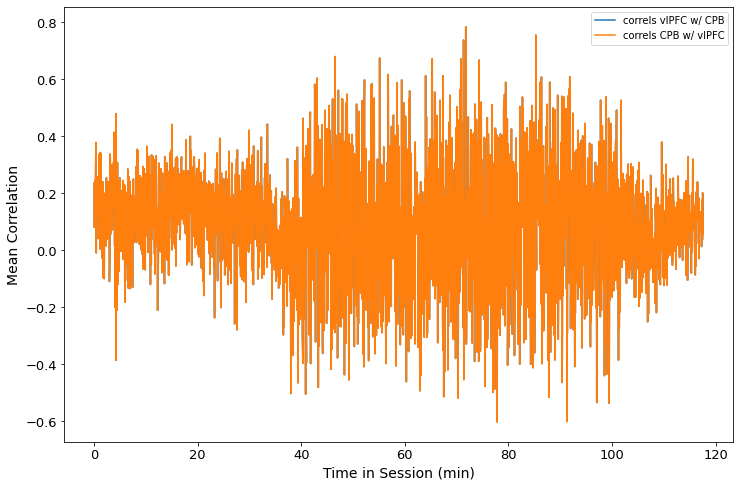

In [32]:
plt.figure(figsize=(12, 8))
for area1, area2 in area_pairs:
    area1_indices = np.where(electrode_info['area'] == area1)[0]
    area2_indices = np.where(electrode_info['area'] == area2)[0]
    mean_correls = [correlations.correlations.iloc[i][area2_indices, :][:, area1_indices].mean() for i in range(len(correlations))]
    plt.plot(correlations.start_time/60, mean_correls, label=f"correls {area1} w/ {area2}")
plt.legend()
plt.xlabel("Time in Session (min)", fontsize=14)
plt.ylabel("Mean Correlation", fontsize=14)
plt.tick_params(labelsize=13)
plt.show()

## Loadings Onto Predictive Dimensions

In [13]:
communication_subspace_projs = {}
for area_pair in area_pairs:
    print(f"{area_pair[0]} --> {area_pair[1]}")
    communication_subspace_projs[area_pair] = np.zeros(len(communication_subspace_data[area_pair])*window)

    area1 = area_pair[0]
    area1_indices = np.where(electrode_info['area'] == area1)[0]
    for i, row in tqdm(communication_subspace_data[area_pair].iterrows(), total=len(communication_subspace_data[area_pair])):
        X = lfp[i*window:(i+1)*window, area1_indices]
#         X = (X - X.mean())/X.std()
        communication_subspace_projs[area_pair][i*window:(i+1)*window] = X@row.B_OLS@row.V[:, :row.d].mean(axis=1)

7b --> CPB


  0%|          | 0/2834 [00:00<?, ?it/s]

7b --> FEF


  0%|          | 0/2834 [00:00<?, ?it/s]

7b --> vlPFC


  0%|          | 0/2834 [00:00<?, ?it/s]

CPB --> 7b


  0%|          | 0/2834 [00:00<?, ?it/s]

CPB --> FEF


  0%|          | 0/2834 [00:00<?, ?it/s]

CPB --> vlPFC


  0%|          | 0/2834 [00:00<?, ?it/s]

FEF --> 7b


  0%|          | 0/2834 [00:00<?, ?it/s]

FEF --> CPB


  0%|          | 0/2834 [00:00<?, ?it/s]

FEF --> vlPFC


  0%|          | 0/2834 [00:00<?, ?it/s]

vlPFC --> 7b


  0%|          | 0/2834 [00:00<?, ?it/s]

vlPFC --> CPB


  0%|          | 0/2834 [00:00<?, ?it/s]

vlPFC --> FEF


  0%|          | 0/2834 [00:00<?, ?it/s]

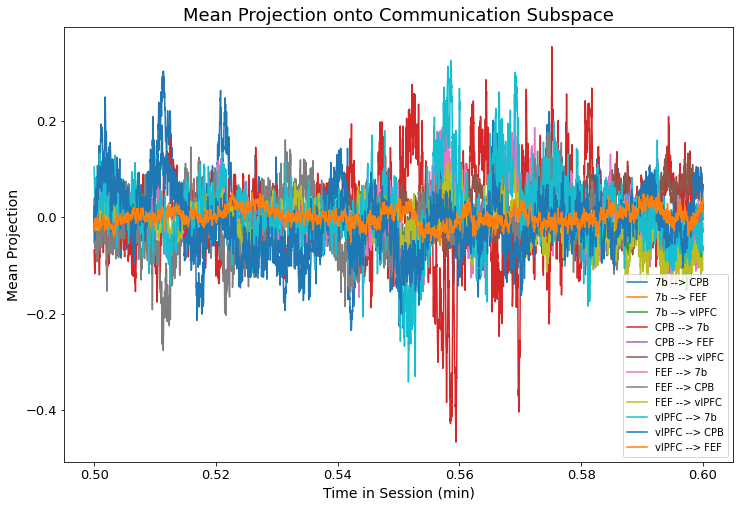

In [15]:
xlim = [0.5, 0.6]
# xlim = [50, 50.1]
# xlim = [0, len(communication_subspace_projs[area_pair])/(1000*60)]
xlim_ms = [int(lim*1000*60) for lim in xlim]
plt.figure(figsize=(12, 8))
min_val = np.Inf
max_val = -np.Inf
for area_pair in area_pairs:
    area1, area2 = area_pair
    plt.plot(np.arange(len(communication_subspace_projs[area_pair]))[xlim_ms[0]:xlim_ms[1]]/(1000*60), communication_subspace_projs[area_pair][xlim_ms[0]:xlim_ms[1]], label=f"{area_pair[0]} --> {area_pair[1]}")
    if communication_subspace_projs[area_pair].min() < min_val:
        min_val = communication_subspace_projs[area_pair].min()
    if communication_subspace_projs[area_pair].max() > max_val:
        max_val = communication_subspace_projs[area_pair].max()
plt.xlabel("Time in Session (min)", fontsize=14)
plt.ylabel("Mean Projection", fontsize=14)
plt.title("Mean Projection onto Communication Subspace", fontsize=18)
plt.tick_params(labelsize=13)
plt.legend()

ax = plt.gca()

# # PLOT LFP
# ax2 = ax.twinx()
# for i, area_pair in enumerate(area_pairs):
#     area1, area2 = area_pair
#     area1_indices = np.where(electrode_info['area'] == area1)[0]
#     ax2.plot(np.arange(lfp.shape[0])[xlim_ms[0]:xlim_ms[1]]/(1000*60), lfp[xlim_ms[0]:xlim_ms[1], area1_indices].mean(axis=1), linestyle='--', label=f"{area1} mean lfp", c=f"C{i + 2}")
# ax2.set_ylabel("LFP (mv)", fontsize=14)
# ax2.legend()
# plt.tick_params(labelsize=13)

# ax.fill_between(np.arange(session_info['drugStart'][0], session_info['drugEnd'][0])/60, 
#                                         min_val, max_val, color='plum', alpha=0.2, label=f"drug infusion 1 - dose = {session_info['drugDose'][0]}")
# ax.fill_between(np.arange(session_info['drugStart'][1], session_info['drugEnd'][1])/60, 
#                     min_val, max_val, color='darkorchid', alpha=0.2, label=f"drug infusion 2 - dose = {session_info['drugDose'][1]}")
# plt.axvline(session_info['eyesClose'][-1]/60 if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose']/60, linestyle='--', c='red', label="loss of consciousness")
# plt.axvline(session_info['eyesOpen'][-1]/60 if isinstance(session_info['eyesOpen'], np.ndarray) else session_info['eyesOpen']/60, linestyle='--', c='green', label="return of consciousness")
plt.show()

In [16]:
mean_CPB_lfp = lfp[:, np.where(electrode_info['area'] == 'CPB')[0]].mean(axis=1)

In [ ]:
communication_subspace_projs[('CPB', 'vlPFC')]

## Factor Analysis (nevermind)

In [33]:
from sklearn.decomposition import FactorAnalysis

In [39]:
window = int(window_s/dt)
num_windows = int(lfp.shape[0]/window)

for area1, area2 in area_pairs:
    area1_indices = np.where(electrode_info['area'] == area1)[0]
    area2_indices = np.where(electrode_info['area'] == area2)[0]
    for i in range(num_windows):
        area1_chunk = lfp[i*window:(i+1)*window, area1_indices]
        area2_chunk = lfp[i*window:(i+1)*window, area2_indices]
        if i == 9:
            break

In [41]:
area1_chunk

array([[ 0.02163483,  0.01980425,  0.02706362, ..., -0.04510645,
        -0.11226327, -0.0155565 ],
       [ 0.01418619,  0.01181237,  0.01811002, ..., -0.05549638,
        -0.12272347, -0.03498343],
       [ 0.00889862,  0.00689425,  0.01086461, ..., -0.05883601,
        -0.11652266, -0.04865189],
       ...,
       [ 0.04879478,  0.06438469,  0.05734591, ...,  0.03495619,
         0.05542727,  0.0323632 ],
       [ 0.04835989,  0.06357583,  0.05624617, ...,  0.03480228,
         0.05167603,  0.03724179],
       [ 0.04815528,  0.06363415,  0.05643855, ...,  0.03298526,
         0.04881567,  0.04046129]])

In [47]:
FA = FactorAnalysis(n_components=10)
X_transformed = FA.fit_transform(area1_chunk)

In [48]:
X_transformed.shape

(2500, 10)